In [1]:
#import some necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
#Read the fake news datasets
fake_df=pd.read_csv('Fake.csv')
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
#Read the real news datasets
real_df=pd.read_csv('real.csv')
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
#add a column "label" as target feature
fake_df['label'] = 0
real_df['label'] = 1

In [5]:
#get the shape of these datasets
fake_df.shape, real_df.shape

((23481, 5), (21417, 5))

In [6]:
#Merging the 2 datasets
news_data = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [7]:
#find missing value
news_data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

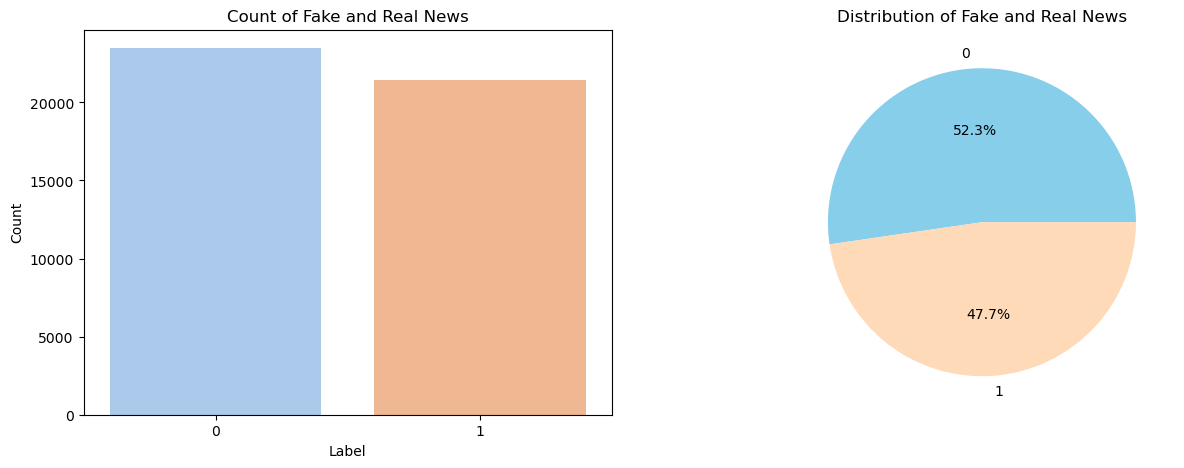

In [8]:
#Data visualizations
 #Count the number of real and fake news in the dataset
label_counts = news_data["label"].value_counts()

#Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot a countplot of the labels in the first subplot
sns.countplot(x="label", data=news_data, ax=ax[0], palette="pastel")
ax[0].set_title("Count of Fake and Real News")
ax[0].set_xlabel("Label")
ax[0].set_ylabel("Count")

# Plot a pie chart of the label distribution in the second subplot
ax[1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', colors=['skyblue', 'peachpuff'])
ax[1].set_title("Distribution of Fake and Real News")

# Display the figure
plt.show()


politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64


Text(0.5, 1.0, 'Distribution of The Subject According to Fake and Real news')

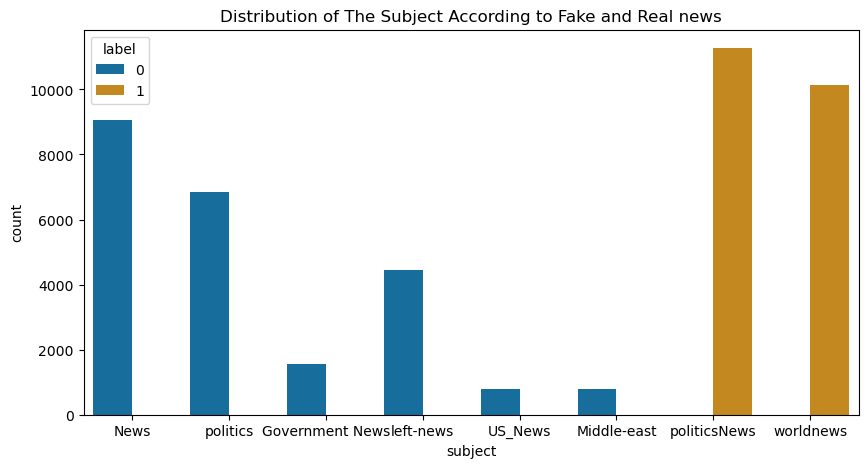

In [9]:
# Count the number of real and fake news in each subject category and plot a countplot
print(news_data.subject.value_counts())
plt.figure(figsize=(10, 5))

ax = sns.countplot(x="subject",  hue='label', data=news_data, palette="colorblind")
plt.title("Distribution of The Subject According to Fake and Real news")

In [10]:
#Removing columns which are not required
df = news_data.drop(["title", "subject","date"], axis = 1)
df.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [11]:
#random shuffiling the datasets
df = df.sample(frac = 1)
df.head()

,text,label
19450,OSU will receive more than $212 million in fed...,0
38576,JAKARTA (Reuters) - Indonesia s military said ...,1
16299,"Pro man-made climate change, RINO Lindsay Grah...",0
25087,SAN FRANCISCO (Reuters) - Facebook Inc (FB.O) ...,1
40766,CARACAS (Reuters) - Venezuela s opposition cri...,1


In [12]:
#reset the index
df = df.reset_index(drop=True)
df.head()

,text,label
0,OSU will receive more than $212 million in fed...,0
1,JAKARTA (Reuters) - Indonesia s military said ...,1
2,"Pro man-made climate change, RINO Lindsay Grah...",0
3,SAN FRANCISCO (Reuters) - Facebook Inc (FB.O) ...,1
4,CARACAS (Reuters) - Venezuela s opposition cri...,1


In [13]:
#Creating a function to preprocess the texts
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W", " ", text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\s+', ' ', text).strip()
    return text


In [14]:
#text processing
df["text"] = df["text"].apply(wordopt)

In [15]:
#Defining dependent and independent variables
x = df['text']
y = df['label']

In [16]:
#Splitting Data into Training and Testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [17]:
#Initialize a TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Fit the vectorizer on the training data and transform both the training and test data
tfidf_train = vectorizer.fit_transform(x_train)
tfidf_test = vectorizer.transform(x_test)

In [18]:
# Initialize DecisionTreeClassifier model
dtc_model = DecisionTreeClassifier()

# Train the model on the vectorized training data and the corresponding labels
dtc_model.fit(tfidf_train, y_train)

# Check if the model has trained successfully
if dtc_model is not None:
    print("Model trained successfully.")
else:
    print("Model training failed.")

Model trained successfully.


In [19]:
#Predict the trained model
dtc_predictions = dtc_model.predict(tfidf_test)

#Calculate the accuracy score of the model on the test data
dtc_accuracy = accuracy_score(y_test, dtc_predictions)
print(f"DTC Accuracy: {round(dtc_accuracy*100, 2)}%")

DTC Accuracy: 99.57%


In [20]:
# Compute confusion matrix for DTC
cm = confusion_matrix(y_test, dtc_predictions)

# Print confusion matrix
print("DTC Confusion Matrix:")
print(cm)

DTC Confusion Matrix:
[[4723   16]
 [  23 4218]]


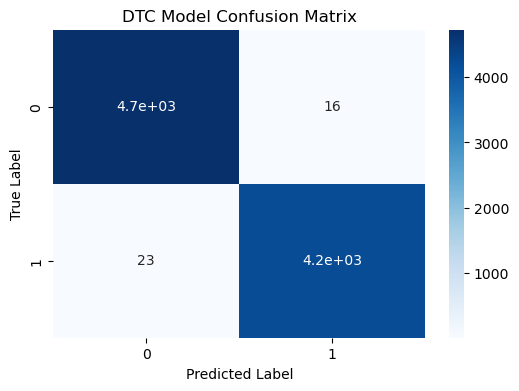

In [21]:
# Generate the confusion matrix for DTC model
con_max = confusion_matrix(y_test, dtc_predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(con_max, annot=True, cmap='Blues')
plt.title('DTC Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [22]:
# Generate the classification report DTC model
print(classification_report(y_test, dtc_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4739
           1       1.00      0.99      1.00      4241

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [23]:
# Initialize LogisticRegression model
lr_model = LogisticRegression()

# Train the model on the vectorized training data and the corresponding labels
lr_model.fit(tfidf_train, y_train)

# Check if the model has trained successfully
if lr_model is not None:
    print("Model trained successfully.")
else:
    print("Model training failed.")

Model trained successfully.


In [24]:
#Predict the trained model
lr_predictions = lr_model.predict(tfidf_test)

#Calculate the accuracy score of the model on the test data
lr_accuracy = accuracy_score(y_test, lr_predictions)
print(f"LR Accuracy: {round(lr_accuracy*100, 2)}%")

LR Accuracy: 98.39%


In [25]:
# Compute confusion matrix for LR
cm = confusion_matrix(y_test, lr_predictions)

# Print confusion matrix
print("LR Confusion Matrix:")
print(cm)

LR Confusion Matrix:
[[4652   87]
 [  58 4183]]


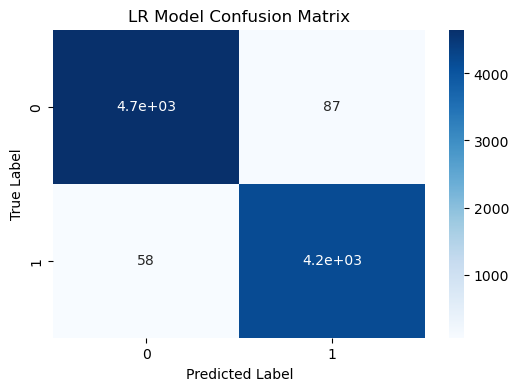

In [26]:
# Generate the confusion matrix for LR model
con_max = confusion_matrix(y_test, lr_predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(con_max, annot=True, cmap='Blues')
plt.title('LR Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [27]:
# Generate the classification report LR model
print(classification_report(y_test, lr_predictions))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4739
           1       0.98      0.99      0.98      4241

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



In [28]:
# Initialize PassiveAggressiveClassifier model
pac_model = PassiveAggressiveClassifier()

# Train the model on the vectorized training data and the corresponding labels
pac_model.fit(tfidf_train, y_train)

# Check if the model has trained successfully
if pac_model is not None:
    print("Model trained successfully.")
else:
    print("Model training failed.")

Model trained successfully.


In [29]:
#Predict the trained model
pac_predictions = pac_model.predict(tfidf_test)

#Calculate the accuracy score of the model on the test data
pac_accuracy = accuracy_score(y_test, pac_predictions)
print(f"PAC Accuracy: {round(pac_accuracy*100, 2)}%")

PAC Accuracy: 99.39%


In [30]:
# Compute confusion matrix for PAC
cm = confusion_matrix(y_test, pac_predictions)

# Print confusion matrix
print("PAC Confusion Matrix:")
print(cm)

PAC Confusion Matrix:
[[4706   33]
 [  22 4219]]


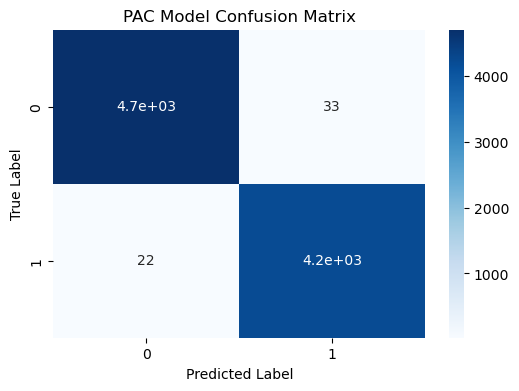

In [31]:
# Generate the confusion matrix for PAC model
con_max = confusion_matrix(y_test, pac_predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(con_max, annot=True, cmap='Blues')
plt.title('PAC Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [32]:
# Generate the classification report PAC model
print(classification_report(y_test, pac_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4739
           1       0.99      0.99      0.99      4241

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [33]:
# Initialize a Gradient Boosting Classifier model
gbc_model = GradientBoostingClassifier()

# Train the model on the vectorized training data and the corresponding labels
gbc_model.fit(tfidf_train, y_train)

# Check if the model has trained successfully
if gbc_model is not None:
    print("Model trained successfully.")
else:
    print("Model training failed.")


Model trained successfully.


In [34]:
# Predict the trained model
gbc_predictions = gbc_model.predict(tfidf_test)

#Calculate the accuracy score of the model on the test data
gbc_accuracy = accuracy_score(y_test, gbc_predictions)
print(f"GBC Accuracy: {round(gbc_accuracy*100, 2)}%")

GBC Accuracy: 99.44%


In [35]:
# Compute confusion matrix for GBC
cm = confusion_matrix(y_test, gbc_predictions)

# Print confusion matrix
print("GBC Confusion Matrix:")
print(cm)

GBC Confusion Matrix:
[[4703   36]
 [  14 4227]]


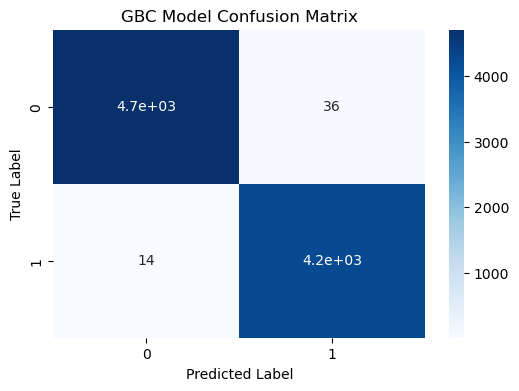

In [36]:
# Generate the confusion matrix for GBC model
con_max = confusion_matrix(y_test, gbc_predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(con_max, annot=True, cmap='Blues')
plt.title('GBC Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [37]:
# Generate the classification report GBC model
print(classification_report(y_test, gbc_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4739
           1       0.99      1.00      0.99      4241

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [38]:
# Initialize RandomForestClassifier model
rfc_model = RandomForestClassifier()

# Train the model on the vectorized training data and the corresponding labels
rfc_model.fit(tfidf_train, y_train)

# Check if the model has trained successfully
if rfc_model is not None:
    print("Model trained successfully.")
else:
    print("Model training failed.")

Model trained successfully.


In [39]:
# Predict the trained model
rfc_predictions = rfc_model.predict(tfidf_test)

#Calculate the accuracy score of the model on the test data
rfc_accuracy = accuracy_score(y_test, rfc_predictions)
print(f"RFC Accuracy: {round(rfc_accuracy*100, 2)}%")

RFC Accuracy: 99.09%


In [40]:
# Compute confusion matrix for RFC
cm = confusion_matrix(y_test, rfc_predictions)

# Print confusion matrix
print("RFC Confusion Matrix:")
print(cm)

RFC Confusion Matrix:
[[4682   57]
 [  25 4216]]


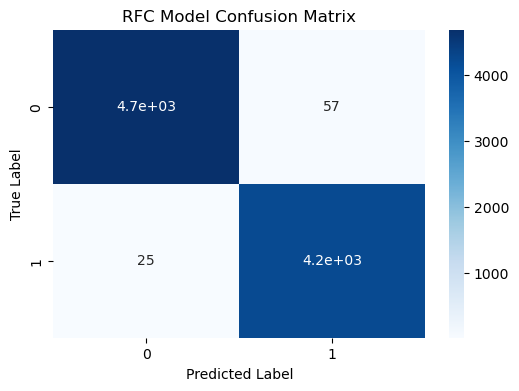

In [41]:
# Generate the confusion matrix for RFC model
con_max = confusion_matrix(y_test, rfc_predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(con_max, annot=True, cmap='Blues')
plt.title('RFC Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [42]:
# Generate the classification report RFC model
print(classification_report(y_test, rfc_predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4739
           1       0.99      0.99      0.99      4241

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

